# Delta hedging of a spread options

Consider a market model with two assets, a Bank account and a 2 Stocks with risk neutral dynamics:

$$
dB(t) = rB(t) dt, \hspace{10mm} B(0) = 1 \\
dS_1(t) = r S_1(t) dt + \sigma_1 S_1(t) dW_1(t), \hspace{10mm} S_1(0) = s_1 > 0 \\
dS_2(t) = r S_2(t) dt + \sigma_2 S_2(t) dW_2(t), \hspace{10mm} S_2(0) = s_2 > 0
$$

where $\sigma_1, \sigma_2 > 0$ and where $E[dW_1(t) dW_2(t)] = \rho dt$ is the correlation between the two Brownian motions.

Consider a spread option with that at time $T$ pays $X = (S_2(T) - S_1(T))^+$.

Chope the time interval between now (time 0) and expiry of the call-option (time $T$) into $N$ pieces; denote the discretization points $t_i$.  

## Margrabe formula for princing the spread option

In the case where the strike price of a spread option is 0 ($K = 0$), there is a closed-form for pricing a spread option the Margrabe formula:

$$
p = x_2 N(d_1) - x_1 N(d_2)
$$

where 

$$
d_{1, 2} = \frac{\ln(x_2 / x_1)}{\sigma \sqrt{T}} \pm \frac{1}{2} \sigma \sqrt{T}
$$

and 

$$
x_1 = S_1(0), x_2 = S_2(0), \hspace{10mm} \sigma^2 = \sigma_1^2 + \sigma_2^2 - 2 \rho \sigma_1 \sigma_2
$$

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..\..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Discrete delta hedging experiment 

The hedging strategy is simple: just calcualte $\Delta_1$ and $\Delta_2$ at each time $t_i$ and then buy $\Delta_1$ units of stock 1 and $\Delta_2$ units of stock 2.

In [2]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import vmap

from jaxfin.models.gbm import MultiGeometricBrownianMotion

from src.spread import margrabe_deltas, margrabe, margrabe_cross_gamma, margrabe_gammas
import scienceplots
plt.style.use(['science','no-latex'])

SEED = 42

Parameters:

$S^1_0$ = $S^2_0$ = 100

$r = 0$

$\sigma_1 = \sigma_2 = 0.2$

$\rho = 0.2$

In [3]:
s0 = jnp.array([100, 100])
means = jnp.array([0.0, 0.0])
vols = jnp.array([0.2, 0.2])
correlation = jnp.array([[1, 0.2], [0.2, 1]], dtype=jnp.float32)

gbm = MultiGeometricBrownianMotion(s0, means, vols, correlation, dtype=jnp.float32)

In [4]:
expiration = 1.0
N = 252
dt = expiration / N
n_simulation = 1

stock_path = gbm.sample_paths(SEED, expiration, N, n_simulation)

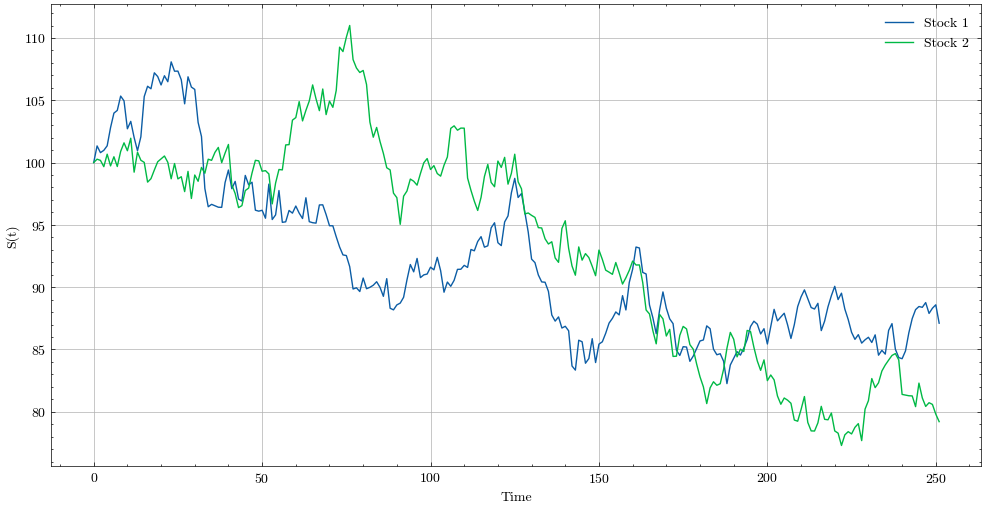

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(stock_path[:, :, 0], label='Stock 1')
plt.plot(stock_path[:, :, 1], label='Stock 2')
plt.ylabel('S(t)')
plt.xlabel('Time')
plt.grid()
plt.legend()
plt.show()

In [6]:
deltas = jnp.asarray([margrabe_deltas(stock_path[i, 0, 0], stock_path[i, 0, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])
spread_value = jnp.asarray([margrabe(stock_path[i, 0, 0], stock_path[i, 0, 1], expiration- i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])
b = [spread_value[0] - deltas[0][0] * stock_path[0, 0, 0] - deltas[0][1] * stock_path[0, 0, 1]]
vs = [spread_value[0]]

for i in range(1, N):
    vs.append(deltas[i - 1][0] * stock_path[i, 0, 0] + deltas[i - 1][1] * stock_path[i, 0, 1] + b[i -1])
    b.append(vs[i] - deltas[i][0] * stock_path[i, 0, 0] - deltas[i][1] * stock_path[i, 0, 1])

hedge_error = jnp.asarray(vs) - jnp.maximum(stock_path[:, 0, 1] - stock_path[:, 0, 0], 0)

In [7]:
print('The final hedge error is: ', hedge_error[-1])

The final hedge error is:  -0.48613298


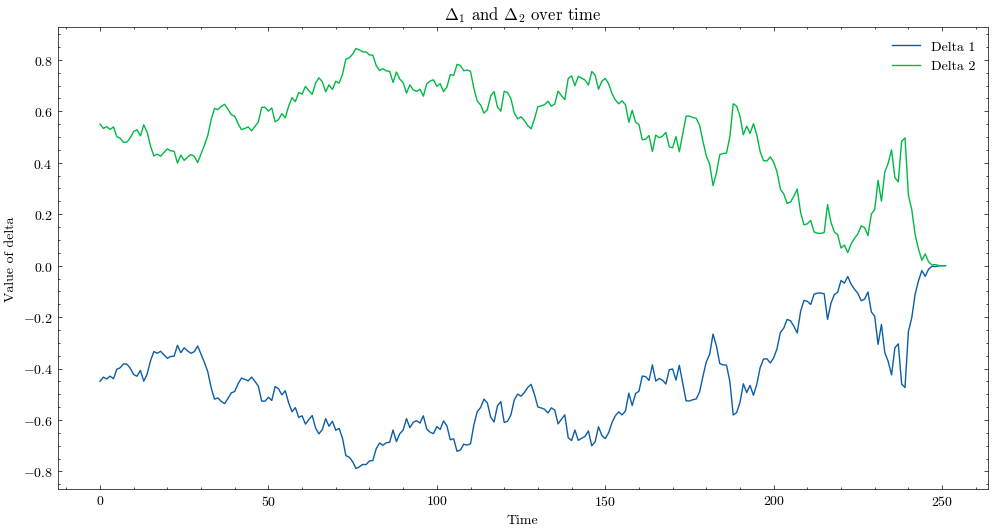

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(deltas[:, 0], label='Delta 1')
plt.plot(deltas[:, 1], label='Delta 2')
plt.title(r'$\Delta_1$ and $\Delta _2$ over time')
plt.xlabel('Time')
plt.ylabel('Value of delta')
plt.legend()
plt.show()

In [9]:
cross_gammas = jnp.asarray([margrabe_cross_gamma(stock_path[i, 0, 0], stock_path[i, 0, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])
gammas = jnp.asarray([margrabe_gammas(stock_path[i, 0, 0], stock_path[i, 0, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])

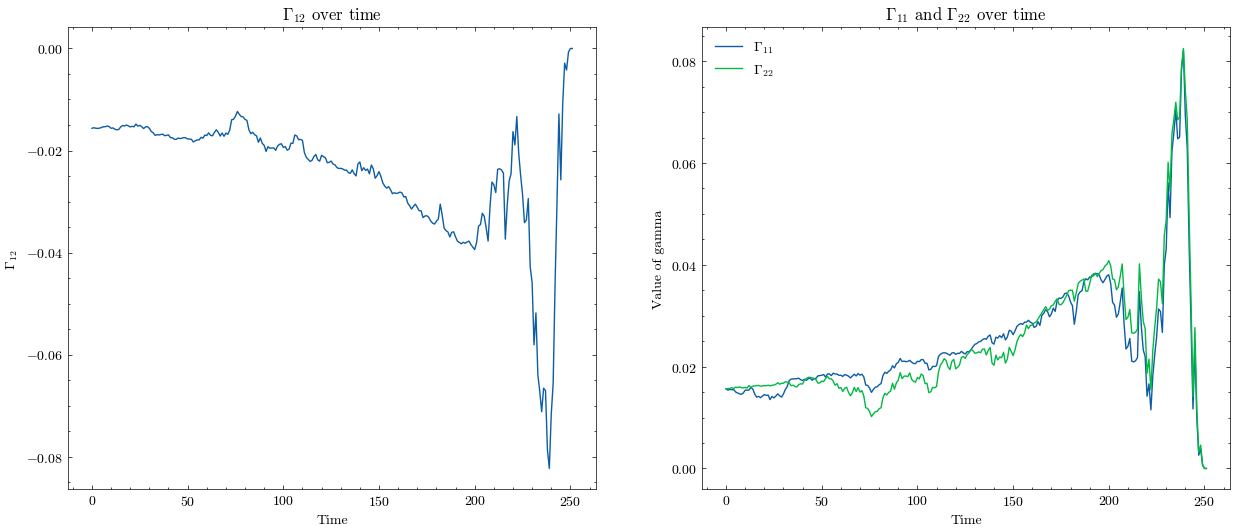

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(cross_gammas[:, 0])
axs[0].set_title(r'$\Gamma_{12}$ over time')
axs[0].set_xlabel('Time')
axs[0].set_ylabel(r'$\Gamma_{12}$')

axs[1].plot(gammas[:, 0], label=r'$\Gamma_{11}$')
axs[1].plot(gammas[:, 1], label=r'$\Gamma_{22}$')
axs[1].set_title(r'$\Gamma_{11}$ and $\Gamma_{22}$ over time')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Value of gamma')
axs[1].legend()

plt.show()

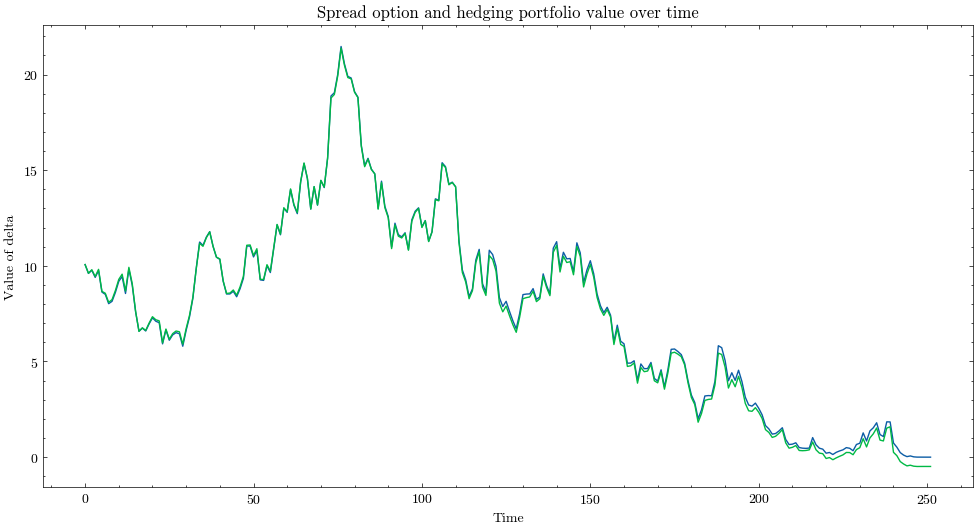

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(spread_value, label='Spread option')
plt.plot(vs, label='Hedging Portfolio')
plt.title('Spread option and hedging portfolio value over time')
plt.xlabel('Time')
plt.ylabel('Value of delta')
plt.show()

## Multiple simulations

In [12]:
n_simulation = 1000

stock_paths = gbm.sample_paths(SEED, expiration, N, n_simulation)

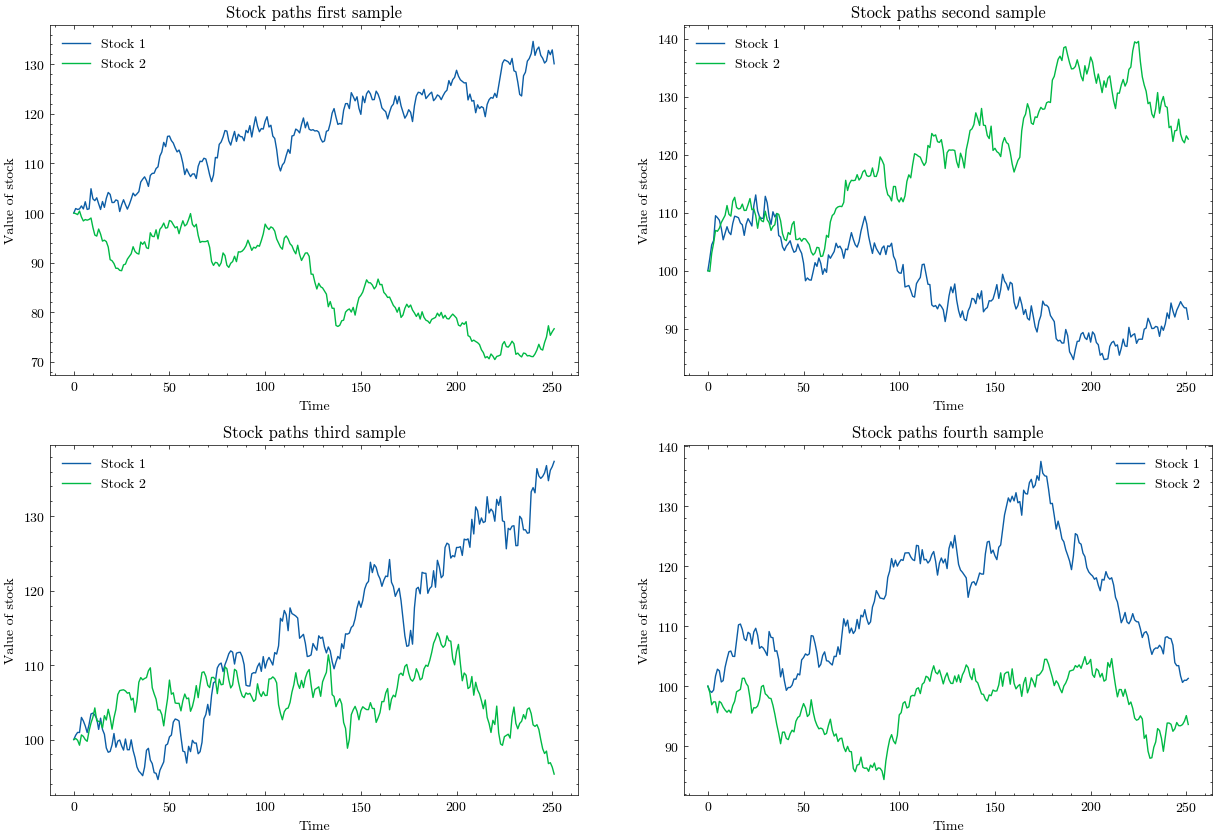

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].plot(stock_paths[:, 0, 0], label='Stock 1')
axs[0, 0].plot(stock_paths[:, 0, 1], label='Stock 2')
axs[0, 0].set_title('Stock paths first sample')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Value of stock')
axs[0, 0].legend()

axs[0, 1].plot(stock_paths[:, 1, 0], label='Stock 1')
axs[0, 1].plot(stock_paths[:, 1, 1], label='Stock 2')
axs[0, 1].set_title('Stock paths second sample')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Value of stock')
axs[0, 1].legend()

axs[1, 0].plot(stock_paths[:, 2, 0], label='Stock 1')
axs[1, 0].plot(stock_paths[:, 2, 1], label='Stock 2')
axs[1, 0].set_title('Stock paths third sample')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Value of stock')
axs[1, 0].legend()

axs[1, 1].plot(stock_paths[:, 3, 0], label='Stock 1')
axs[1, 1].plot(stock_paths[:, 3, 1], label='Stock 2')
axs[1, 1].set_title('Stock paths fourth sample')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Value of stock')
axs[1, 1].legend()

plt.show()

In [14]:
vmap_deltas = vmap(margrabe_deltas, in_axes=(0, 0, None, None, None, None))

In [15]:
deltas = jnp.asarray([vmap_deltas(stock_paths[i, :, 0], stock_paths[i, :, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])
spread_value = jnp.asarray([margrabe(stock_paths[i, :, 0], stock_paths[i, :, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])
b = [spread_value[0, :] - deltas[0, :, 0] * stock_paths[0, :, 0] - deltas[0, :, 1] * stock_paths[0, :, 1]]
vs = [spread_value[0, :]]

for i in range(1, N):
    vs.append(deltas[i - 1, :, 0] * stock_paths[i, :, 0] + deltas[i - 1, :, 1] * stock_paths[i, :, 1] + b[i - 1])
    b.append(vs[i] - deltas[i, :, 0] * stock_paths[i, :, 0] - deltas[i, :, 1] * stock_paths[i, :, 1])

hedge_error = jnp.asarray(vs)[-1] - jnp.maximum(stock_paths[-1:, :, 1] - stock_paths[-1:, :, 0], 0)

In [16]:
print(f"The mean hedge error is: {jnp.mean(hedge_error[-1, :]):.5f}")
print(f"The standard deviation of the hedge error is: {(jnp.std(hedge_error[-1, :]) / spread_value[0,0 ]):.5f}")

The mean hedge error is: -0.00362
The standard deviation of the hedge error is: 0.05629


### Try with a different $\rho$

$\rho = -0.7$

In [17]:
rho = -0.7

correlation = jnp.array([[1, rho], [rho, 1]], dtype=jnp.float32)

gbm = MultiGeometricBrownianMotion(s0, means, vols, correlation, dtype=jnp.float32)
stock_paths = gbm.sample_paths(SEED, expiration, N, n_simulation)

In [18]:
deltas = jnp.asarray([vmap_deltas(stock_paths[i, :, 0], stock_paths[i, :, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])
spread_value = jnp.asarray([margrabe(stock_paths[i, :, 0], stock_paths[i, :, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])
b = [spread_value[0, :] - deltas[0, :, 0] * stock_paths[0, :, 0] - deltas[0, :, 1] * stock_paths[0, :, 1]]
vs = [spread_value[0, :]]

for i in range(1, N):
    vs.append(deltas[i - 1, :, 0] * stock_paths[i, :, 0] + deltas[i - 1, :, 1] * stock_paths[i, :, 1] + b[i - 1])
    b.append(vs[i] - deltas[i, :, 0] * stock_paths[i, :, 0] - deltas[i, :, 1] * stock_paths[i, :, 1])

hedge_error = jnp.asarray(vs)[-1] - jnp.maximum(stock_paths[-1:, :, 1] - stock_paths[-1:, :, 0], 0)

In [19]:
print(f"The mean hedge error is: {jnp.mean(hedge_error[-1, :]):.5f}")
print(f"The standard deviation of the hedge error is: {(jnp.std(hedge_error[-1, :]) / spread_value[0,0 ]):.5f}")

The mean hedge error is: 0.92612
The standard deviation of the hedge error is: 0.05750


$\rho = 0.8$

In [23]:
rho = 0.8

correlation = jnp.array([[1, rho], [rho, 1]], dtype=jnp.float32)

gbm = MultiGeometricBrownianMotion(s0, means, vols, correlation, dtype=jnp.float32)
stock_paths = gbm.sample_paths(SEED, expiration, N, n_simulation)

In [24]:
deltas = jnp.asarray([vmap_deltas(stock_paths[i, :, 0], stock_paths[i, :, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])
spread_value = jnp.asarray([margrabe(stock_paths[i, :, 0], stock_paths[i, :, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])
b = [spread_value[0, :] - deltas[0, :, 0] * stock_paths[0, :, 0] - deltas[0, :, 1] * stock_paths[0, :, 1]]
vs = [spread_value[0, :]]

for i in range(1, N):
    vs.append(deltas[i - 1, :, 0] * stock_paths[i, :, 0] + deltas[i - 1, :, 1] * stock_paths[i, :, 1] + b[i - 1])
    b.append(vs[i] - deltas[i, :, 0] * stock_paths[i, :, 0] - deltas[i, :, 1] * stock_paths[i, :, 1])

hedge_error = jnp.asarray(vs)[-1] - jnp.maximum(stock_paths[-1:, :, 1] - stock_paths[-1:, :, 0], 0)

In [25]:
print(f"The mean hedge error is: {jnp.mean(hedge_error[-1, :]):.5f}")
print(f"The standard deviation of the hedge error is: {(jnp.std(hedge_error[-1, :]) / spread_value[0,0 ]):.5f}")

The mean hedge error is: -3.12084
The standard deviation of the hedge error is: 0.30265


$\rho = 0$

In [26]:
rho = 0.0

correlation = jnp.array([[1, rho], [rho, 1]], dtype=jnp.float32)

gbm = MultiGeometricBrownianMotion(s0, means, vols, correlation, dtype=jnp.float32)
stock_paths = gbm.sample_paths(SEED, expiration, N, n_simulation)

In [27]:
deltas = jnp.asarray([vmap_deltas(stock_paths[i, :, 0], stock_paths[i, :, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])
spread_value = jnp.asarray([margrabe(stock_paths[i, :, 0], stock_paths[i, :, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])
b = [spread_value[0, :] - deltas[0, :, 0] * stock_paths[0, :, 0] - deltas[0, :, 1] * stock_paths[0, :, 1]]
vs = [spread_value[0, :]]

for i in range(1, N):
    vs.append(deltas[i - 1, :, 0] * stock_paths[i, :, 0] + deltas[i - 1, :, 1] * stock_paths[i, :, 1] + b[i - 1])
    b.append(vs[i] - deltas[i, :, 0] * stock_paths[i, :, 0] - deltas[i, :, 1] * stock_paths[i, :, 1])

hedge_error = jnp.asarray(vs)[-1] - jnp.maximum(stock_paths[-1:, :, 1] - stock_paths[-1:, :, 0], 0)

In [28]:
print(f"The mean hedge error is: {jnp.mean(hedge_error[-1, :]):.5f}")
print(f"The standard deviation of the hedge error is: {(jnp.std(hedge_error[-1, :]) / spread_value[0,0 ]):.5f}")

The mean hedge error is: 0.03173
The standard deviation of the hedge error is: 0.05782
